In [2]:
import streamlit as st
import matplotlib.pyplot as plt
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.prompts import PromptTemplate
from pydantic import BaseModel
from typing import List
import pandas as pd
import json

persistent_directory=r"C:\Users\ekene\OneDrive\Documents\DataScienceProjects\skill-importance-project\prototype\db\chroma_db_with_metadata"

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

db = Chroma(
    persist_directory=persistent_directory,
    embedding_function=embeddings,
    collection_name="jobs_collection"  # Match the name used in push
    )

In [3]:
# Pydantic model to structure the skills and their importance
class SkillData(BaseModel):
    skill: str
    importance: int

class SkillsResponse(BaseModel):
    skills: List[SkillData]



# Function to retrieve job postings (e.g., ChromaDB vector store)
def retrieve_job_postings(query, db):

    # Retrieve relevant documents based on the query
    retriever = db.as_retriever(
        search_type="similarity_score_threshold",
        search_kwargs={"k": 40, "score_threshold": 0.4},  # Lower threshold for testing
    )
    # `k`: Top # of document hits 
    # `score_threshold`: Similarity score from text document to query
    relevant_docs = retriever.invoke(query)
    return relevant_docs

In [4]:
x=retrieve_job_postings('computer engineer',db)

In [7]:
import re
# Function to extract skills from the job posting dynamically (LLM-based)
def extract_skills_from_job_posting(job_posting: str) -> SkillsResponse:
    # Define the prompt template
    template = """
    Extract the top skills from all jobs provided and their importance (on a scale from 1 to 100):

    {job_posting}

    Return the skills in this format: [{{'skill': 'Skill Name', 'importance': 95}}, ...]
    """
    # Create a PromptTemplate instance
    prompt_template = PromptTemplate(
        input_variables=["job_posting"],  # Define the placeholder(s)
        template=template
    )
    prompt = prompt_template.format(job_posting=job_posting)


    # Use the LLM (ChatGPT) to extract the skills and importance scores
    response = ChatOpenAI(model="gpt-4o").invoke(prompt)

    skills_data = []
    
    # Parse the response into structured data (SkillsResponse format)
    pattern = re.compile(r"```json\s*(.*?)\s*```", re.DOTALL)
    match = pattern.search(response.content)
    if match:
        json_str = match.group(1) # This is the JSON string
        try:
            json_str=json_str.replace("'", '"')
            skills_data = json.loads(json_str) # Convert JSON string to Python object (list of dicts)
        except json.JSONDecodeError as e:
            print("JSON decode error:", e)
    else:
        print("No JSON content was found.")
    
    # Validate and structure the data using Pydantic
    structured_skills = SkillsResponse.model_validate({"skills": 
                                                       [SkillData(skill=skill['skill'], 
                                                                  importance=skill['importance']) 
                                                                  for skill in skills_data]})
    
    return structured_skills
   

SR=extract_skills_from_job_posting('/n'.join([job.page_content for job in x ]))

<function matplotlib.pyplot.show(close=None, block=None)>

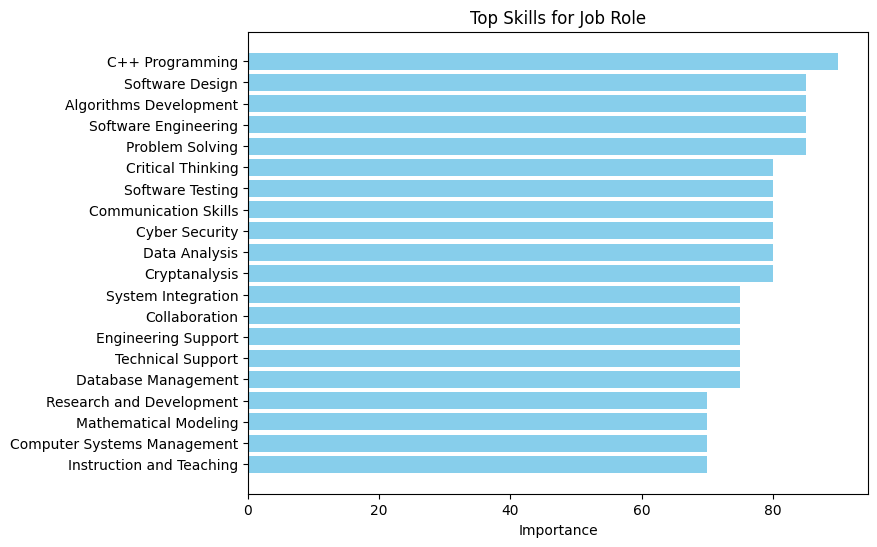

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# Function to plot the skills and importance

skills = [skill.skill for skill in SR.skills]
importance = [skill.importance for skill in SR.skills]

# Create the plot
skills_df = pd.DataFrame({
    "Skill": skills,
    "Importance": importance
})
skills_df.sort_values(by='Importance',inplace=True)

plt.figure(figsize=(8, 6))
plt.barh(skills_df["Skill"], skills_df["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.title("Top Skills for Job Role")
plt.show


In [ ]:
# Define Tools: one for skill extraction, and one for plotting
extract_skills_tool = Tool(
    name="Skill Extractor",
    func=extract_skills_from_job_posting,
    description="Extracts the top skills and their importance from the job posting."
)

plot_tool = Tool(
    name="Top Skills Plotter",
    func=plot_skills,
    description="Generates a plot of the top skills required for the job role."
)

""" query_tool = Tool(
    name="Job Query Responder",
    func=retrieve_job_postings,
    description="Responds with relevant job postings based on the query."
) """

# Set up LangChain agent
llm = ChatOpenAI(model="gpt-4o")
tools = [extract_skills_tool, plot_tool]

# Initialize agent with tools
agent = initialize_agent(tools, llm, agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)

# Streamlit input for query
query = st.text_input("Ask a question:")

if query:
    # Use the agent to choose which tools to use based on the query
    response = agent.run(query)
    st.write(response)
